import all the necesarry library

In [1]:
import numpy as np
import pywt
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import math
from scipy.fftpack import dct
from scipy.fftpack import idct


# Functions 

Function Convert and resize image 

In [2]:
def convertImage(imageName, size,imName):
    img = Image.open(imageName).resize((size, size), 1)
    # Convert RGB image to gray scale
    img = img.convert('L')
    # Storing the gray scale image   
    if (imName != None):
        img.save('processedInputImage/' + imName)
    imageArray = np.array(img.getdata(), dtype=float).reshape((size, size))
    return imageArray

def convertMark(imageName, size,imName):
    mark = Image.open(imageName).resize((size, size), 1)
    # Convert RGB image to gray scale
    mark = mark.convert('L')
    # Converting the gray scale image to binary image
    mark = mark.point(lambda x: 0 if x < 128 else maxVal, '1')
    # Inverting the binary image if there are more 255s than 0s
    if (np.sum(mark) > (size * size / 2)):
        mark = mark.point(lambda x: 0 if x == maxVal else maxVal, '1')
    # Storing the binary image
    if (imName != None):
        mark.save('processedInputImage/' + imName)
    markArray = np.array(mark.getdata(), dtype=float).reshape((size, size))
    return markArray

Function that embedded watermark image into cover image

In [3]:
# Embed watermark into the cover image
def embedWatermark(watermarkArray, originalImage):
    watermarkArraySize = len(watermarkArray[0])
    watermarkFlat = watermarkArray.ravel() # ravel() is used to convert 2D array to 1D array
    ind = 0

    for x in range (0, len(originalImage), 8):
        for y in range (0, len(originalImage), 8):
            if ind < len(watermarkFlat):
                subdct = originalImage[x:x+8, y:y+8]
                subdct[5][5] = watermarkFlat[ind]
                originalImage[x:x+8, y:y+8] = subdct
                ind+= 1
    return originalImage

Function that apply Discrete Cosine Transform on an 8x8 block

In [4]:
# DCT transform on image, i.e. image array
def applyDCT(imageArray):
    size = len(imageArray[0])
    allSubdct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subpixels = imageArray[i:i+8, j:j+8]
            subdct = dct(dct(subpixels.T, norm="ortho").T, norm="ortho")
            allSubdct[i:i+8, j:j+8] = subdct
    return allSubdct


Function that apply Inverse Discrete Cosine Transform on an 8x8 block

In [5]:
def inverseDCT(allSubdct):
    size = len(allSubdct[0])
    allSubidct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subidct = idct(idct(allSubdct[i:i+8, j:j+8].T, norm="ortho").T, norm="ortho")
            allSubidct[i:i+8, j:j+8] = subidct

    return allSubidct


Function that extract watermark image from embedded image

In [6]:
def getWatermark(dctWatermarkedCoeff, watermarkSize):
    subwatermarks = []
    for x in range (0, len(dctWatermarkedCoeff), 8):
        for y in range (0, len(dctWatermarkedCoeff), 8):
            coeffSlice = dctWatermarkedCoeff[x:x+8, y:y+8]
            subwatermarks.append(coeffSlice[5][5])
    watermark = np.array(subwatermarks).reshape(watermarkSize, watermarkSize)
    return watermark

Function that recover watermark image using 2 key

In [7]:
def recoverWatermark(image):
    coeffsWatermarkedImage=list(pywt.wavedec2(data = image, wavelet = 'haar', level = 1))
    dctWatermarkedCoeff = applyDCT(coeffsWatermarkedImage[0])
    watermarkArray = getWatermark(dctWatermarkedCoeff, 128)
    watermarkArray =  np.uint8(watermarkArray)
    #Save result
    #img = Image.fromarray(watermarkArray)
    #img.save('result/recoveredWatermark.png')
    return watermarkArray

Function for save image

In [8]:
def printImage(imageArray, name):
    imageArrayCopy = imageArray.clip(0, 255)
    imageArrayCopy = imageArrayCopy.astype("uint8")
    img = Image.fromarray(imageArrayCopy)
    img.save('result/' + name)

Function that embedded watermark image into cover
image

In [9]:
def embeddedImage(coverImage, watermarkImage):

    fileName, fileType = coverImage.split(".")
    imageArray = convertImage(coverImage, 2048, "1."+fileType)
    #watermarkArray = convertImage(watermarkImage, 128, "2."+fileType)
    watermarkArray = convertMark(watermarkImage, 128, "2."+fileType)
    np.set_printoptions(threshold=np.inf)

    coeffsImage = list(pywt.wavedec2(data=imageArray, wavelet = 'haar', level = 1))
    
    dctArray = applyDCT(coeffsImage[0])
    dctArray = embedWatermark(watermarkArray, dctArray)

    coeffsImage[0] = inverseDCT(dctArray)

    imageArrayH=pywt.waverec2(coeffsImage, 'haar')
    

    #printImage(imageArrayH, fileName+'_watermarkedImage.jpg'+fileType)
    printImage(imageArrayH, 'watermarkedImage.jpg')
    printImage(imageArrayH, 'watermarkedImage.png')
    return imageArrayH

In [10]:
def jpegCorrection(watermarkArray):
    # Convertion de toutes les valeur entre 40 et 60 en 255 et le reste en 0
    #watermarkArray[watermarkArray > 66] = 255 # Blanc
    #watermarkArray[watermarkArray > 220] = 255 # Blanc
    watermarkArray[watermarkArray > 32] = 255 # Blanc
    #watermarkArray[watermarkArray < 36] = 255
    #watermarkArray[watermarkArray < 180] = 255
    watermarkArray[watermarkArray < 12] = 255
    watermarkArray[watermarkArray != 255] = 0 # Noir -> Marque
    return watermarkArray

# Testing

In [14]:
maxVal = 34 

image = "original/image.jpg"
marque = "original/marque.png"

#todo : key à ajouter
#watermarkeImage = embeddedImage("lena.png","logo.png") 
watermarkeImage = embeddedImage(image,marque) 

In [15]:
watermarkeImage = cv2.imread("result/watermarkedImage.jpg",0)
watermarkArray = recoverWatermark(watermarkeImage)
#print(watermarkArray)

# Correction de la compression jpeg du watermark récupéré
#watermarkArray = jpegCorrection(watermarkArray)

#Save result
img = Image.fromarray(watermarkArray)
img.save('result/recoveredWatermark.png')

# Plot all three resultant image

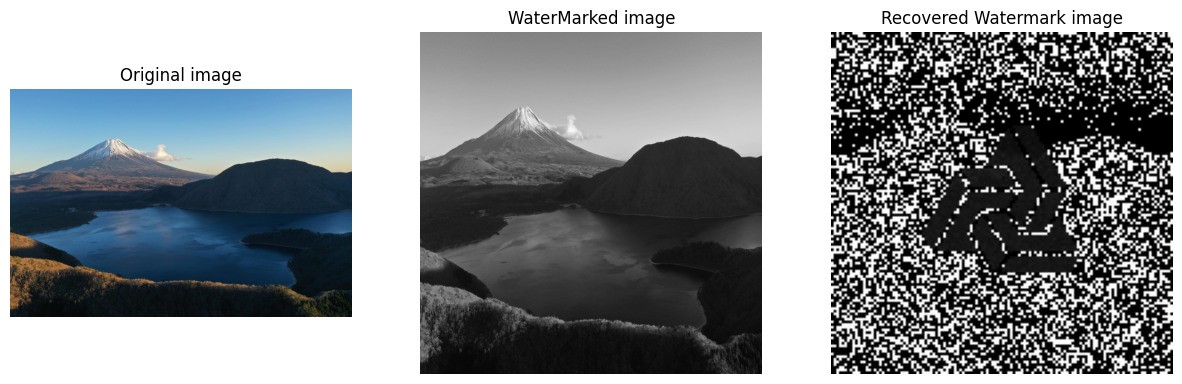

In [16]:
import matplotlib.pyplot as plt
import cv2

readImage = cv2.imread(image, cv2.COLOR_BGR2RGB)
waterimg = cv2.imread("result/watermarkedImage.jpg")
recovwater = cv2.imread("result/recoveredWatermark.png")

plt.figure(figsize = (15,15))
plt.subplot(1,3,1),plt.imshow(cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)),plt.title("Original image"), plt.axis('off')
plt.subplot(1,3,2),plt.imshow(waterimg),plt.title("WaterMarked image"), plt.axis("off")
plt.subplot(1,3,3),plt.imshow(recovwater),plt.title("Recovered Watermark image"), plt.axis("off")
plt.show()

---

# Calculate PSNR value

In [278]:
def pastingImage (img1, img2):
    temp = img2.copy()
    x_offset=y_offset=50
    img2[y_offset:y_offset+img1.shape[0], x_offset:x_offset+img1.shape[1]] = img1
    
    return img2, temp

In [279]:
def compute_psnr(img1, img2):
    
    img1 = img1.astype(float) / 255.
    img2 = img2.astype(float) / 255.
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return "Same Image"
    return 10 * math.log10(1. / mse)

In [280]:
def NCC(img1, img2):
    return abs(np.mean(np.multiply((img1-np.mean(img1)),(img2-np.mean(img2))))/(np.std(img1)*np.std(img2)))

In [281]:
img1 = cv2.imread("original/image.jpg",0)
img1 = cv2.resize(img1, (512, 512))
img2 = cv2.imread("result/watermarkedImage.jpg",0)
img1, img2 = pastingImage(img1,img2)

psnr = compute_psnr(img1, img2)
print (f'PSNR value of resultant image is {psnr}')

PSNR value of resultant image is 19.66264978716173


In [282]:
print (f'Normalized cross correlation is {NCC(img1, img2)}')

Normalized cross correlation is 0.9151549169001189


# Attacks (Geometric & Signal Processing)

In [283]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col= image.shape
        mean = 0
        #var = 0.001
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col))
        gauss = gauss.reshape(row,col)
        #noisy = image + gauss
        noisy = image + image * gauss
        return noisy
    elif noise_typ == "s&p":
        row,col = image.shape
        s_vs_p = 0.5
        #amount = 0.01 # 0.10% of pixels ?
        amount = 0.0003
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image)) 
        vals = 2 ** np.ceil(np.log2(vals))
        #noisy = np.random.poisson(image * vals) / float(vals) 
        noisy = np.random.poisson(image * vals) / float(vals) * 3
        return noisy
    elif noise_typ =="speckle":
        row,col = image.shape
        gauss = np.random.randn(row,col)
        gauss = gauss.reshape(row,col)        
        #noisy = image + image * gauss
        noisy = image + image * gauss*0.5
        return noisy
    elif noise_typ == "rotate90" :
        angle = 90
        scale = 1.0
        w = image.shape[1]
        h = image.shape[0]
        rangle = np.deg2rad(angle)  # angle in radians
        nw = (abs(np.sin(rangle) * h) + abs(np.cos(rangle) * w)) * scale
        nh = (abs(np.cos(rangle) * h) + abs(np.sin(rangle) * w)) * scale
        rot_mat = cv2.getRotationMatrix2D((nw * 0.5, nh * 0.5), angle, scale)
        rot_move = np.dot(rot_mat, np.array(
            [(nw - w) * 0.5, (nh - h) * 0.5, 0]))
        rot_mat[0, 2] += rot_move[0]
        rot_mat[1, 2] += rot_move[1]
        noisy=cv2.warpAffine(image, rot_mat, (int(math.ceil(nw)), int(math.ceil(nh))), flags=cv2.INTER_LANCZOS4)
        return noisy
    elif noise_typ=="chop30":
        img = image.copy()
        w, h = img.shape[:2]
        noisy=img[int(w * 0.3):, :]
        return noisy


In [284]:
def restoreCrop(img):
    # Add null information to the borders of a cropped image to make it 2048x2048 in size:
    # Get the dimensions of the cropped image
    height, width = img.shape

    # Create a new black image of size 2048x2048
    new_img = np.zeros((2048, 2048), dtype=np.uint8)

    # Calculate the position to place the cropped image in the center of the new image
    x_offset = int((2048 - width) / 2)
    y_offset = int((2048 - height) / 2)

    # Add the cropped image to the center of the new image
    new_img[y_offset:y_offset+height, x_offset:x_offset+width] = img

    return new_img

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
				 Geometric Attacks
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


				 Rotate 90°
-----------------------------------------------------------------------------------------


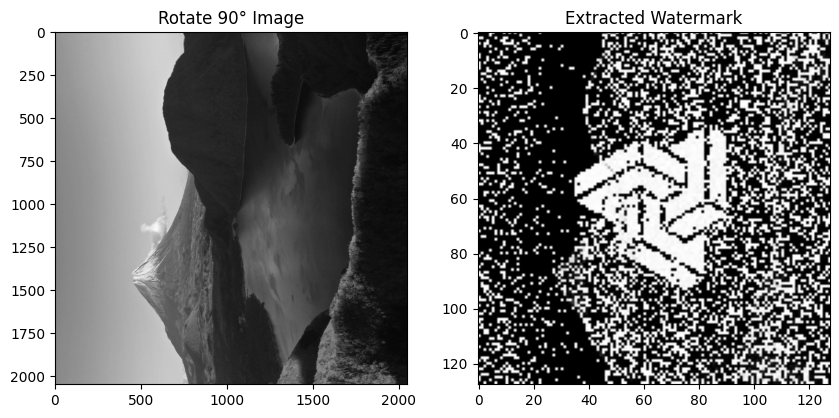

			 Normalized cross correlation is  0.9534045434863232
******************************************************************************************
				 Chop 30
-----------------------------------------------------------------------------------------


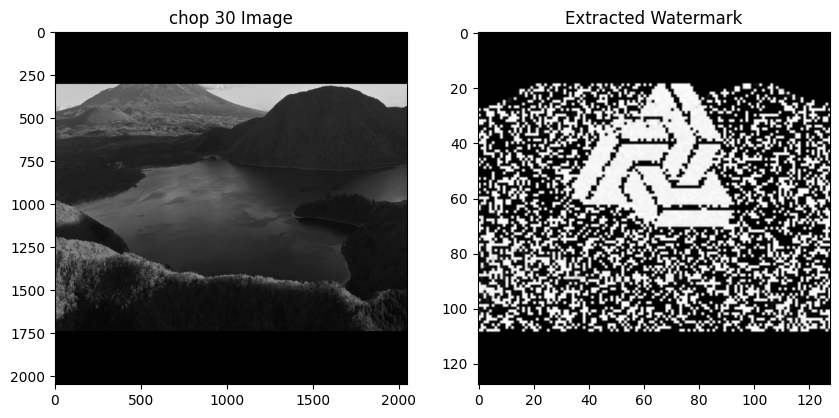

			 Normalized cross correlation is  0.8924402074237363
******************************************************************************************
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
				 Image Filtering Attacks
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


				 Gaussian Noise 
-----------------------------------------------------------------------------------------


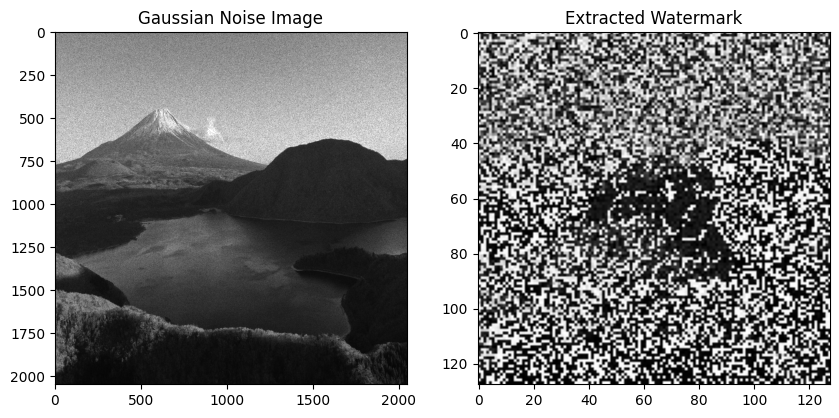

			 Normalized cross correlation is  0.9574652381285151
******************************************************************************************
				 Salt and Pepper Noise
-----------------------------------------------------------------------------------------


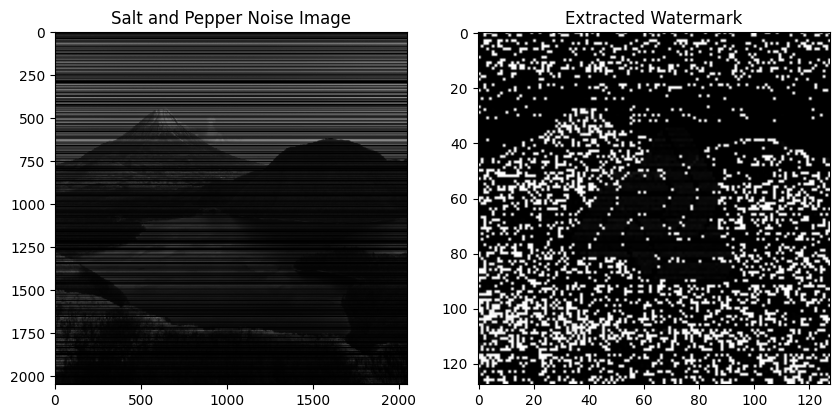

			 Normalized cross correlation is  0.9421836524955257
******************************************************************************************
				 Poisson Noise
-----------------------------------------------------------------------------------------


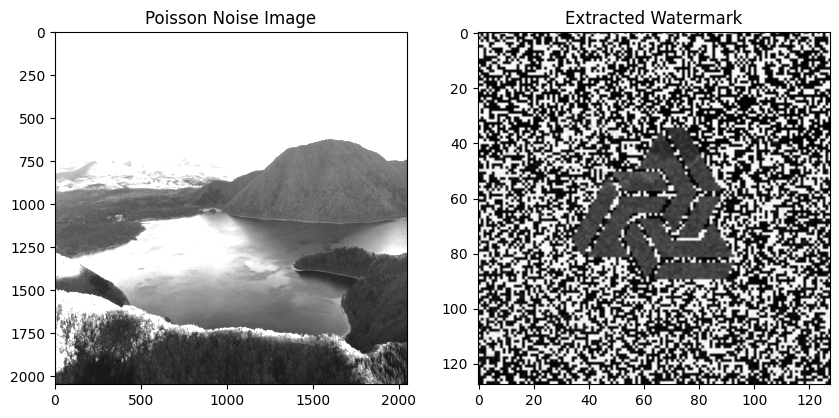

			 Normalized cross correlation is  0.928604135116512
******************************************************************************************
				 Speckle Noise
-----------------------------------------------------------------------------------------


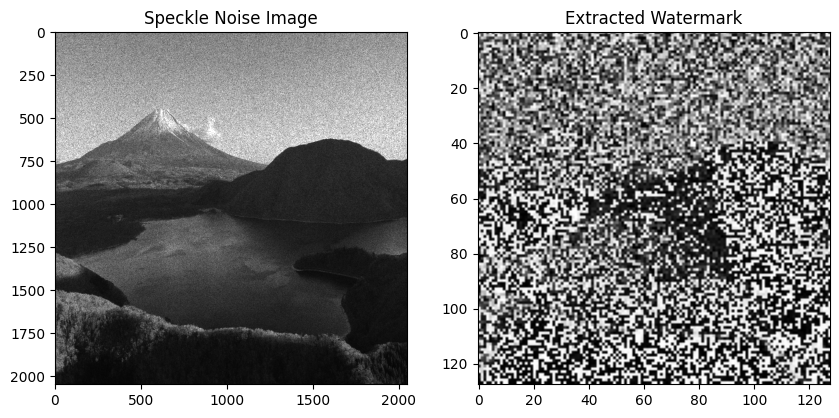

			 Normalized cross correlation is  0.9584846222975214
******************************************************************************************


In [285]:
originalImage = cv2.imread("original/image.jpg", cv2.IMREAD_GRAYSCALE)
originalImage = cv2.resize(originalImage, (512, 512))
originalMarque = cv2.imread("original/marque.jpg", cv2.IMREAD_GRAYSCALE)

watermarked = cv2.imread("result/watermarkedImage.jpg", 0)
#extracted = cv2.imread("result/recoveredWatermark.png", cv2.IMREAD_GRAYSCALE)


print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print ('\t\t\t\t Geometric Attacks')
print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n\n')

print ("\t\t\t\t Rotate 90°")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "rotate90",watermarked)
extracted = recoverWatermark(img)
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Rotate 90° Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage,img),img))
print ("******************************************************************************************")
print ("\t\t\t\t Chop 30")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "chop30",watermarked)
img = restoreCrop(img)
extracted = (recoverWatermark(img)) # Image.fromarray(recoverWatermark(img))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("chop 30 Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage,img),img))
print ("******************************************************************************************")

print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print ('\t\t\t\t Image Filtering Attacks')
print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n\n')

print ("\t\t\t\t Gaussian Noise ")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "gauss",watermarked)
extracted = (recoverWatermark(img))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Gaussian Noise Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage,img),img))
print ("******************************************************************************************")

print ("\t\t\t\t Salt and Pepper Noise")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "s&p",watermarked)
extracted = (recoverWatermark(img))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Salt and Pepper Noise Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage,img),img))
print ("******************************************************************************************")

print ("\t\t\t\t Poisson Noise")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "poisson",watermarked)
extracted = (recoverWatermark(img))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Poisson Noise Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage, img), img))
print ("******************************************************************************************")

print ("\t\t\t\t Speckle Noise")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "speckle",watermarked)
extracted = (recoverWatermark(img))
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Speckle Noise Image")
plt.subplot(1,2,2), plt.imshow(extracted, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Extracted Watermark")
plt.show()
print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage, img), img))
print ("******************************************************************************************")